# Propagation phase metasurface

Metasurface design using the propagation phase.

## 0. Prepare

In [1]:
import importlib.util
# import lumapi
spec = importlib.util.spec_from_file_location('lumapi', 'D:\\Program Files\\Lumerical\\v241\\api\\python\\lumapi.py')
lumapi = importlib.util.module_from_spec(spec)
spec.loader.exec_module(lumapi)

In [2]:
import time
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import klayout.db as db  # use klayout package to generate GDS file

In [3]:
# import custom modules
sys.path.append("../module")
from FieldPropagation import fieldPropagationLumapi, em_field
from MetaTool import nk2permittivity, setResources, getMatrixCenter, phaseDis

## 1. Constants, classes and functions

In [4]:
# colorbar setting
cmap_amp = "Reds"  # amplitude use
cmap_ang = "RdBu_r"  # angle (phase) use

## 2. Meta-atom library building

Here we build a meta-atom library for the further metasurface design. 
The meta-atoms are cylinders, which are polarization-insensitive. 

In simulation, we use the x-polarized incident light.

### 2.1 Params

In [5]:
# parameters
# control parameters
hide = False  # whether to hide GUI or not

# spectral
wavelength_number = 1  # the number of discrete points of the spectral
wavelength = 633e-9  # [m]
wavelength_min = wavelength
wavelength_max = wavelength
source_polarization = np.deg2rad(0)  # the angle of polarization to the x axis [rad]

# meta-atom
unit_size = 300e-9  # unit size [m]
offset_x = 1 / 2 * unit_size - unit_size / 2  # the offset of unit in the x direction relative to the center
offset_y = 1 / 2 * unit_size - unit_size / 2  # the offset of unit in the y direction relative to the center

# simulation objects
material_atom = "TiO2"
material_substrate = "Al2O3 - Palik"

separation = wavelength_max / 2  # safe spacing between the objects and simulation boundaries
sep_ub_t = separation  # spacing between upper bound and transmission plane
sep_t_atom = separation  # spacing between transmission plane and atom
sep_interface_source = separation * 0.5  # spacing between interface (atom / substrate) and source
sep_source_lb = separation * 0.5  # spacing between source and lower bound
height_atom = 500e-9  # [m]
height_substrate = separation * 2  # [m]. If 0, no substrate

# simulation size
sim_x_span = unit_size
sim_y_span = unit_size
sim_z_span = sep_ub_t + sep_t_atom + height_atom + sep_interface_source + sep_source_lb

# boundary conditions: PML / Period / Bloch / (Anti-)Symmetric
boundary_x_min = "Period"
boundary_x_max = "Period"
boundary_y_min = "Period"
boundary_y_max = "Period"
boundary_z_min = "PML"
boundary_z_max = "PML"

# mesh settings (automate mesh)
mesh_accuracy = 2

# atom structure (initial parameters)
radius_atom = 120e-9  # [m]

### 2.2 Library building

#### 2.2.1 Simulation prepare

In [6]:
# open fdtd
fdtd = lumapi.FDTD(hide=hide)
print(">> Progress: FDTD is opened.")

>> Progress: FDTD is opened.


In [7]:
# add material
material_name = "TiO2"
material_df = pd.read_csv("../material/TiO2.csv")
material_np = np.array(material_df)
# obtain the frequency array
wavelength_array = material_np[:, 0] * 1e-6  # [m]
frequency_array = fdtd.c() / wavelength_array
# obtain the complex permittivity array from (n, k)
permittivity_array = nk2permittivity(material_np[:, 1], material_np[:, 2])
# combine
sampled_data = np.vstack((frequency_array, permittivity_array)).T
# add
temp = fdtd.addmaterial("Sampled data")
fdtd.setmaterial(temp, "name", material_name)  # rename the material
fdtd.setmaterial(material_name, "max coefficients", 6)  # set the number of coefficients
fdtd.setmaterial(material_name, "color", np.array([255 / 255, 69 / 255, 0 / 255, 1]))
fdtd.setmaterial(material_name, "sampled data", sampled_data)
print(">> Progress: Adding material " + material_name + " is done.")

>> Progress: Adding material TiO2 is done.


In [8]:
# resource settings 
parallel_job_number = 6
processes = 1
threads = 1
capacity = 1
job_launching_preset = "Remote: Intel MPI"  # "Remote: Microsoft MPI" / "Remote: Intel MPI"

setResources(fdtd, parallel_job_number=parallel_job_number, processes=processes, \
    threads=threads, capacity=capacity, job_launching_preset=job_launching_preset)

In [9]:
# define basic objects
# make sure in layout mode
if fdtd.layoutmode() != 1:  # layoutmode() return 0 when in analysis mode
    fdtd.switchtolayout()

fdtd.deleteall()  # clear objects

# source
source = fdtd.addplane(
    name="source",
    # size
    x=0,
    x_span=sim_x_span,
    y=0,
    y_span=sim_y_span,
    z=-sep_interface_source,
    # propagation direction
    injection_axis="z",
    direction="forward",
    angle_theta=0,
    angle_phi=0,
    amplitude=1,
    # polarization direction
    polarization_angle=np.rad2deg(source_polarization),
    # phase
    phase=0,
    # bandwidth
    wavelength_start=wavelength_min,
    wavelength_stop=wavelength_max,
)

# FDTD
sim_region = fdtd.addfdtd(
    dimension="3D",
    x=0.0,
    x_span=sim_x_span,
    y=0.0,
    y_span=sim_y_span,
    z_min=-(sep_interface_source + sep_source_lb),
    z_max=height_atom + sep_t_atom + sep_ub_t,
    # boundary condition
    x_min_bc=boundary_x_min,
    x_max_bc=boundary_x_max,
    y_min_bc=boundary_y_min,
    y_max_bc=boundary_y_max,
    z_min_bc=boundary_z_min,
    z_max_bc=boundary_z_max,
    pml_layers=8,
    auto_shutoff_min=1e-5,
    mesh_accuracy=mesh_accuracy
)

# monitor
fdtd.setglobalmonitor("frequency points", wavelength_number)  # global settings
power_profile_t = fdtd.addpower(
    name="power profile T",
    monitor_type="2D Z-normal",
    x=0.0,
    x_span=sim_x_span,
    y=0.0,
    y_span=sim_y_span,
    z=height_atom + sep_t_atom,
)

# structure
substrate = fdtd.addrect(
    name="substrate",
    x=0.0, 
    y=0.0,
    x_span=sim_x_span,
    y_span=sim_y_span,
    z_max=0,
    z_min=-height_substrate,
    material=material_substrate
)

# meta-atom
atom = fdtd.addcircle(
    name="atom",
    x=0 * unit_size - offset_x,
    y=0 * unit_size - offset_y,
    radius=radius_atom,
    z_min=0,
    z_max=height_atom,
    material=material_atom
)

#### 2.2.2 Iteration

In [10]:
# set the iteration range of the values of radius of meta-atom
radius_vec = np.arange(40e-9, 140e-9, 5e-9)

# the following variables will be used to store the calculation result
phase_vec = np.zeros(len(radius_vec))
t_vec = np.zeros(len(radius_vec))

In [12]:
# parallel
# prepare simulation files
for i in range(len(radius_vec)):
    # switch layout
    if fdtd.layoutmode() != 1:
        fdtd.switchtolayout()
    # modify params
    atom.radius = radius_vec[i]
    # save simulation
    file_name = "../fsp/propagation_atom_" + str(i) + ".fsp"
    fdtd.save(file_name)
    fdtd.addjob(file_name)
    
fdtd.runjobs()  # run jobs in parallel

# obtain data
for i in range(len(radius_vec)):
    file_name = "../fsp/propagation_atom_" + str(i) + ".fsp"
    fdtd.load(file_name)
    mesh_x_vec = fdtd.getdata(power_profile_t.name, 'x').reshape(-1)
    mesh_y_vec = fdtd.getdata(power_profile_t.name, 'y').reshape(-1)
    e_x_mat = fdtd.getdata(power_profile_t.name, 'Ex')[:, :, 0, 0]
    phase_vec[i] = getMatrixCenter(np.angle(e_x_mat))
    t_vec[i] = fdtd.getresult(power_profile_t.name, 'T')['T'][0]

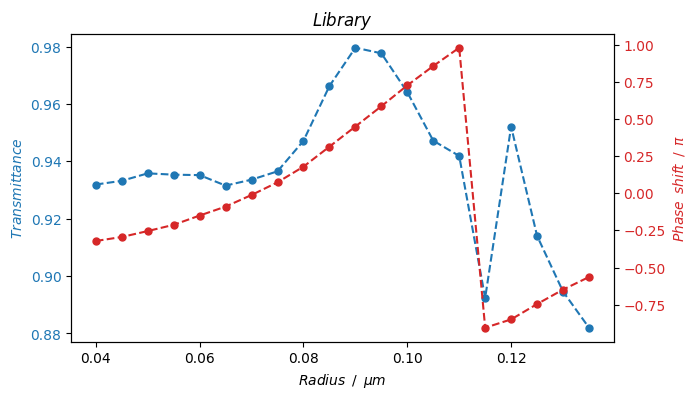

In [13]:
# draw the iteration result
fig, ax1 = plt.subplots(figsize=(7, 4))

color = 'tab:blue'
ax1.set_xlabel(r"$Radius \enspace / \enspace \mu m$")
ax1.set_ylabel(r"$Transmittance$", color=color)
ax1.plot(radius_vec * 1e6, t_vec, linestyle="--", linewidth=1.5, marker="o", markersize=5, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel(r'$Phase \enspace shift \enspace / \enspace \pi$', color=color)
ax2.plot(radius_vec * 1e6, phase_vec / np.pi, linestyle="--", linewidth=1.5, marker="o", markersize=5, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title(r"$Library$")
plt.show()

In [14]:
# save library
with open('../data/propagation_library.npy', 'wb') as f:
    np.save(f, radius_vec)
    np.save(f, phase_vec)
    np.save(f, t_vec)

## 3. Metasurface design

Design the propagation phase metasurface composed of meta-atoms with different radius.

We use the metasurface hologram as an example.

The library built above will be used.

### 3.1 Importing design destination

In [15]:
# import destination phase profile (in space domain) from matlab
phase_profile_dest = np.load("../data/hologram_phase_20_20.npy")
rows, cols = phase_profile_dest.shape  # the row and column number of pattern

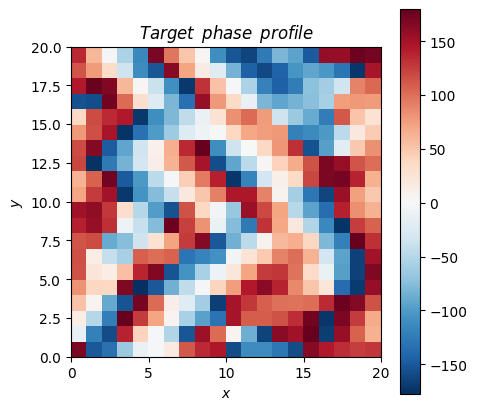

In [16]:
# draw the spatial phase profile
fig = plt.figure(figsize=(5, 5))
c = plt.pcolor(np.rad2deg(phase_profile_dest), cmap=cmap_ang)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("$Target \enspace phase \enspace profile$")
fig.colorbar(c)
plt.gca().set_aspect(1)
plt.show()

### 3.2 Arrangement of library meta-atoms

In [17]:
# parameters
units_rows = rows  # the number of rows of metasurface units
units_cols = cols  # the number of columns of metasurface units
offset_x = units_cols / 2 * unit_size - unit_size / 2  # the offset of metasurface in the x direction relative to the center
offset_y = units_rows / 2 * unit_size - unit_size / 2  # the offset of metasurface in the y direction relative to the center

# update simulation size
sim_x_span = unit_size * units_cols
sim_y_span = unit_size * units_rows

# update boundary conditions
boundary_x_min = "PML"
boundary_x_max = "PML"
boundary_y_min = "PML"
boundary_y_max = "PML"
boundary_z_min = "PML"
boundary_z_max = "PML"

In [18]:
# load library
with open('../data/propagation_library.npy', 'rb') as f:
    radius_vec = np.load(f)
    phase_vec = np.load(f)
    t_vec = np.load(f)

In [19]:
def fom(phase_dest, phase, t):
    """ 
    Figure of merit 
    """
    tolerance_phase = np.deg2rad(5)  # phase error we can tolerate considering solving accuracy
    lambda_phase = 2e0  # weight for phase item
    lambda_t = 1e0  # weight for transmittance item
    return phaseDis(phase, phase_dest) * (phaseDis(phase, phase_dest) > tolerance_phase) * lambda_phase + \
        (-1) * t * lambda_t

In [20]:
# sort phase and make dictionary of index and order
phase_sort_vec = sorted(enumerate(phase_vec), key=lambda x:x[1])
index_order_dict = {phase_sort_vec[i][0]: i for i in range(len(phase_sort_vec))}
order_index_dict = {i: phase_sort_vec[i][0] for i in range(len(phase_sort_vec))}

In [21]:
# choose suitable meta-atom from library
units_pos_r_dict = {}  # dictionary for metasurface units (position and radius)
for i in range(units_rows):
    for j in range(units_cols):
        phase_dest = phase_profile_dest[i, j]
        matched = False
        tolerance = np.deg2rad(15)
        while not matched:
            index_begin = 0
            index_end = len(phase_sort_vec) - 1
            # special cases
            if phase_sort_vec[index_end][1] <= phase_dest - tolerance:
                index_begin = index_end
            elif phase_sort_vec[index_begin][1] >= phase_dest + tolerance:
                index_end = index_begin
            # general case
            else:
                while phase_sort_vec[index_begin][1] < phase_dest - tolerance:
                    index_begin += 1
                while phase_sort_vec[index_end][1] > phase_dest + tolerance:
                    index_end -= 1

            if index_end < index_begin:
                # not matched
                tolerance *= 2
            else:
                # range: [index_begin, index_end]
                fom_min = np.inf
                index_lib_best = 0
                for ii in range(index_begin, index_end + 1, 1):
                    index = order_index_dict[ii]
                    fom_current = fom(phase_dest, phase_vec[index], t_vec[index])
                    if fom_current < fom_min:
                        fom_min = fom_current
                        index_lib_best = index
                units_pos_r_dict[(i, j)] = radius_vec[index_lib_best]
                matched = True

### 3.3 Simulation

In [27]:
# resource settings 
parallel_job_number = 1
processes = 6
threads = 1
capacity = 1
job_launching_preset = "Remote: Intel MPI"  # "Remote: Microsoft MPI" / "Remote: Intel MPI"

setResources(fdtd, parallel_job_number=parallel_job_number, processes=processes, \
    threads=threads, capacity=capacity, job_launching_preset=job_launching_preset)

In [28]:
# define basic objects
# make sure in layout mode
if fdtd.layoutmode() != 1:  # layoutmode() return 0 when in analysis mode
    fdtd.switchtolayout()

fdtd.deleteall()  # clear objects

# source
source = fdtd.addplane(
    name="source",
    # size
    x=0,
    x_span=sim_x_span,
    y=0,
    y_span=sim_y_span,
    z=-sep_interface_source,
    # propagation direction
    injection_axis="z",
    direction="forward",
    angle_theta=0,
    angle_phi=0,
    amplitude=1,
    # polarization direction
    polarization_angle=np.rad2deg(source_polarization),
    # phase
    phase=0,
    # bandwidth
    wavelength_start=wavelength_min,
    wavelength_stop=wavelength_max,
)

# FDTD
sim_region = fdtd.addfdtd(
    dimension="3D",
    x=0.0,
    x_span=sim_x_span,
    y=0.0,
    y_span=sim_y_span,
    z_min=-(sep_interface_source + sep_source_lb),
    z_max=height_atom + sep_t_atom + sep_ub_t,
    # boundary condition
    x_min_bc=boundary_x_min,
    x_max_bc=boundary_x_max,
    y_min_bc=boundary_y_min,
    y_max_bc=boundary_y_max,
    z_min_bc=boundary_z_min,
    z_max_bc=boundary_z_max,
    pml_layers=8,
    auto_shutoff_min=1e-5,
    mesh_accuracy=mesh_accuracy
)

# monitor
fdtd.setglobalmonitor("frequency points", wavelength_number)  # global settings
power_profile_t = fdtd.addpower(
    name="power profile T",
    monitor_type="2D Z-normal",
    x=0.0,
    x_span=sim_x_span,
    y=0.0,
    y_span=sim_y_span,
    z=height_atom + sep_t_atom,
)

# substrate
substrate = fdtd.addrect(
    name="substrate",
    x=0.0, 
    y=0.0,
    x_span=sim_x_span,
    y_span=sim_y_span,
    z_max=0,
    z_min=-height_substrate,
    material=material_substrate
)
# meta-atoms
atoms = []
for pos in units_pos_r_dict:
    x = pos[1] * unit_size - offset_x
    y = pos[0] * unit_size - offset_y
    radius = units_pos_r_dict[pos]
    atoms.append(fdtd.addcircle(
        name="atom_" + str(pos[0]) + "/" + str(pos[1]),
        x=x,
        y=y,
        radius=radius,
        z_min=0,
        z_max=height_atom,
        material=material_atom
    ))

In [43]:
fdtd.save("../fsp/propagation_metasurface.fsp")  # save simulation

In [44]:
t1 = time.perf_counter()  # begin time count
fdtd.run()  # run
t2 = time.perf_counter()  # end time count
print("Run time cost: {}s.".format(t2 - t1))

Run time cost: 38.23820959999989s.


### 3.4 Analysis

Here we just analyze the near field. 

The detailed analysis of metasurface hologram can be found in another notebook `MetasurfaceHologramDesign.ipynb`.

In [45]:
# obtain data
mesh_x_vec = fdtd.getdata(power_profile_t.name, 'x')[:, 0]
mesh_y_vec = fdtd.getdata(power_profile_t.name, 'y')[:, 0]
power_profile_t_e = fdtd.getresult(power_profile_t.name, 'E')
e_t_x_mat = power_profile_t_e['E'][:, :, 0, 0, 0]
e_t_y_mat = power_profile_t_e['E'][:, :, 0, 0, 1]
e_t_z_mat = power_profile_t_e['E'][:, :, 0, 0, 2]
t = fdtd.getresult(power_profile_t.name, 'T')['T'][0]

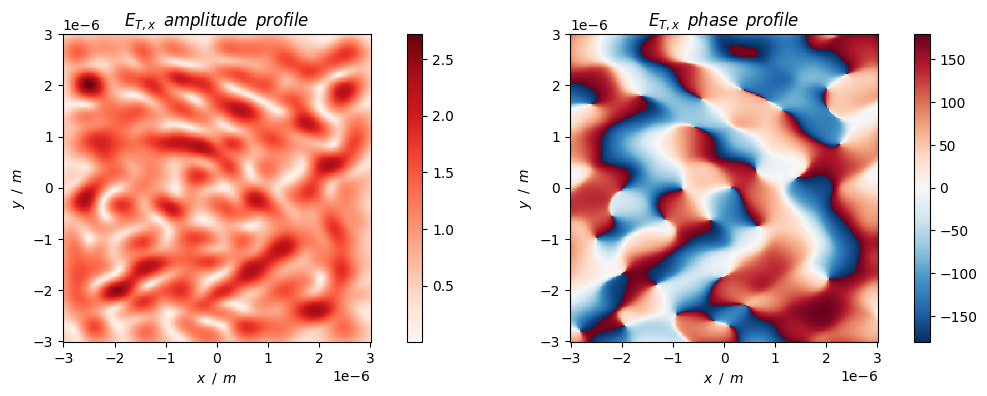

In [46]:
# draw the near field distribution
sep = 1  # sample the dense monitor data

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
c = plt.pcolor(
    mesh_x_vec[::sep],
    mesh_y_vec[::sep],
    np.abs(e_t_x_mat[::sep, ::sep]).T, 
    cmap=cmap_amp
)
fig.colorbar(c)
plt.xlabel(r"$x \enspace / \enspace m$")
plt.ylabel(r"$y \enspace / \enspace m$")
plt.title(r"$E_{T, x} \enspace amplitude \enspace profile$")
plt.axis("scaled")

plt.subplot(1, 2, 2)
c = plt.pcolor(
    mesh_x_vec[::sep],
    mesh_y_vec[::sep],
    np.rad2deg(np.angle(e_t_x_mat[::sep, ::sep])).T, 
    cmap=cmap_ang
)
fig.colorbar(c)
plt.xlabel(r"$x \enspace / \enspace m$")
plt.ylabel(r"$y \enspace / \enspace m$")
plt.title(r"$E_{T, x} \enspace phase \enspace profile$")
plt.axis("scaled")
plt.show()

In [47]:
t

0.7889436557905283

In [48]:
# close FDTD
fdtd.close()

### 3.5 GDS file export

In [ ]:
ly = db.Layout()
ly.dbu = 1e-4  # sets the database unit to 0.1 nm
top_cell = ly.create_cell("TOP")
layer = ly.layer(1, 0)
# draw objects
for pos in units_pos_r_dict:
    x = (pos[1] * unit_size - offset_x) * 1e6  # [um]
    y = (pos[0] * unit_size - offset_y) * 1e6  # [um]
    r = units_pos_r_dict[pos] * 1e6  # [um]
    top_cell.shapes(layer).insert(db.DPolygon.ellipse(
      db.DBox(x - r, y - r, x + r, y + r), 
      64))  # add a circle
ly.write("../layout/propagation_metasurface.gds")